# 🚀 **LIGHT MODEL : pipeline complet**

Pipeline **content-based** simple, rapide et optimisé pour le CPU.

**Caractéristiques :**
- Léger et reproductible
- Pas de dépendances GPU
- Idéal pour prototypage ou petits datasets

**Étapes :**
1. Charge la configuration YAML
2. Charge le dataset (`anime_master_clean.csv`)
3. Construit les vecteurs de features :
   - TF-IDF sur les synopsis (10k tokens max)
   - One-hot encoding des genres
   - Normalisation des features numériques
4. Concatène les features en une matrice unique
5. Construit un modèle KNN exact (`sklearn`)
6. Sauvegarde :
   - Matrice des features (`features.npz`)
   - Métadonnées (`metadata.json`)
   - Modèle KNN (`knn_model.pkl`)
   - Configuration utilisée (`config_used.yaml`)
   - Logs d'exécution (`training.log`)
7. Optionnel : auto-benchmark (précision/latence)

**Sorties :**

project/
├── features.npz
├── metadata.json
├── knn_model.pkl
├── config_used.yaml
└── training.log


**Avantages :**
✅ Rapide à entraîner (<1 min pour 30k animes)
✅ Faible consommation mémoire
✅ Pas de dépendances complexes

**Cas d'usage :**
- Prototypage rapide
- Environnements sans GPU
- Tests de base avant passage au modèle Premium


In [4]:
# ============================================================
# Notebook : 03_train_content_light
# Objectif : Entraînement du modèle Content-Based LIGHT v2
# Pipeline : TF-IDF + Genres + Numerical → KNN
# ============================================================

import os
import json
import yaml
import joblib
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from scipy import sparse

from datetime import datetime

In [5]:
# ============================================================
# Chargement configuration
# ============================================================

# %cd ..
# ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))

# config_path = os.path.join(ROOT, "anime-recommender-", "config", "content_light.yaml")
config_path = "../config/content_light.yaml"
print("Loading:", config_path)

with open(config_path, "r") as f:
    config = yaml.safe_load(f)


Loading: ../config/content_light.yaml


In [6]:
# ============================================================
# Chargement du dataset
# ============================================================

#df_path = config["data"].get("dataset_path")
# df_path = "./data/processed/anime_master_clean.csv"
# if df_path is None:
#     raise ValueError("❌ dataset_path manquant dans le YAML.")

# df = pd.read_csv(df_path)
df = pd.read_csv("../data/processed/anime_master_clean.csv")
df = df.dropna(subset=["synopsis"])
df = df.reset_index(drop=True)
print("Dataset:", df.shape)

Dataset: (23827, 23)


In [7]:
# Normalisation de la colonne genre
import ast

def fix_list(x):
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except:
            return []
    return x

df["genres_list"] = df["genres_list"].apply(fix_list)
df["genres_list"] = df["genres_list"].apply(lambda lst: [g.strip() for g in lst])
df["genres_str"] = df["genres_list"].apply(lambda lst: ", ".join(lst))

from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
genre_sparse = mlb.fit_transform(df["genres_list"])



In [8]:
# ============================================================
# Run directory
# ============================================================

run_id = datetime.now().strftime("%Y%m%d_%H%M%S")
run_dir = f"runs/content_light/{run_id}"
os.makedirs(run_dir, exist_ok=True)


In [9]:
# ============================================================
# Organisation dossiers (artifacts + reports + figures)
# ============================================================

artifacts_dir = os.path.join(run_dir, "artifacts")
reports_dir   = os.path.join(run_dir, "reports")
figures_dir   = os.path.join(reports_dir, "figures")

os.makedirs(artifacts_dir, exist_ok=True)
os.makedirs(figures_dir, exist_ok=True)


In [10]:
# ============================================================
# 1. TF-IDF
# ============================================================

tfidf_params = config["model"]["tfidf"]
vectorizer = TfidfVectorizer(
    max_features=tfidf_params["max_features"],
    ngram_range=tuple(tfidf_params["ngram_range"]),
    min_df=tfidf_params["min_df"],
    stop_words="english"
)

tfidf = TfidfVectorizer(max_features=20000)
tfidf_matrix = tfidf.fit_transform(df["synopsis"].fillna(""))


In [11]:
# ============================================================
# 2. One-Hot Genres
# ============================================================

if "genres_str" in df.columns:
    genre_matrix = df["genres_str"].fillna("").str.get_dummies(sep=", ")
else:
    genre_matrix = pd.DataFrame()
if len(genre_matrix) > 0:
    genre_sparse = sparse.csr_matrix(genre_matrix.values)
    print("Genres:", genre_sparse.shape)
else:
    genre_sparse = None
    print("Aucun genre trouvé.")

print(df.columns)
df["genres_str"].head()
df["genres_str"].str.get_dummies(sep=", ").head()
df.loc[df["title"].str.contains("Naruto", case=False)][[
    "title", "genres_list", "genres_str", "genres_count"
]]


Genres: (23827, 21)
Index(['mal_id', 'title', 'title_norm', 'type', 'rating', 'year',
       'genres_list', 'genres_str', 'genres_count', 'themes_list',
       'themes_str', 'themes_count', 'synopsis', 'synopsis_length', 'score',
       'weighted_score', 'members', 'popularity', 'completion_rate',
       'drop_rate', 'fav_count', 'image_url', 'studios'],
      dtype='object')


,title,genres_list,genres_str,genres_count
2371,Boruto: Naruto Next Generations,"[Action, Adventure, Fantasy]","Action, Adventure, Fantasy",3
2372,Boruto: Naruto the Movie,"[Action, Adventure, Fantasy]","Action, Adventure, Fantasy",3
2373,Boruto: Naruto the Movie - Naruto ga Hokage ni...,"[Action, Adventure, Fantasy]","Action, Adventure, Fantasy",3
9584,Kamiusagi Rope x Boruto: Naruto Next Generations,[Comedy],Comedy,1
14073,Naruto,"[Action, Adventure, Fantasy]","Action, Adventure, Fantasy",3
14074,Naruto (Shinsaku Anime),"[Action, Adventure, Fantasy]","Action, Adventure, Fantasy",3
14075,Naruto Movie 1: Dai Katsugeki!! Yuki Hime Ninp...,"[Action, Adventure, Fantasy]","Action, Adventure, Fantasy",3
14076,Naruto Movie 2: Dai Gekitotsu! Maboroshi no Ch...,"[Action, Adventure, Fantasy]","Action, Adventure, Fantasy",3
14077,Naruto Movie 3: Dai Koufun! Mikazuki Jima no A...,"[Action, Adventure, Fantasy]","Action, Adventure, Fantasy",3
14078,Naruto Narutimate Hero 3: Tsuini Gekitotsu! Jo...,[Action],Action,1


In [12]:
# ============================================================
# 3. Features numériques (normalisées)
# ============================================================

num_cols = ["score", "members", "episodes", "duration"]
num_cols = [c for c in num_cols if c in df.columns]

if len(num_cols) > 0:
    scaler = MinMaxScaler()
    num_scaled = scaler.fit_transform(df[num_cols].fillna(0))
    num_sparse = sparse.csr_matrix(num_scaled)
    print("Numerical:", num_sparse.shape)
else:
    num_sparse = None
    print("Aucune feature numérique.")

Numerical: (23827, 2)


In [13]:
# ============================================================
# 4. Concaténation GLOBAL FEATURES
# ============================================================

parts = [tfidf_matrix]

if genre_sparse is not None:
    parts.append(genre_sparse)

if num_sparse is not None:
    parts.append(num_sparse)

features = sparse.hstack(parts).tocsr()

print("Final feature matrix:", features.shape)




Final feature matrix: (23827, 20023)


In [14]:
# ============================================================
# 5. KNN (brute force cosine)
# ============================================================

knn_params = config["model"]["knn"]
knn = NearestNeighbors(
    n_neighbors=knn_params["n_neighbors"],
    metric="cosine",
    algorithm="brute"
)

knn.fit(features)
print("KNN trained (cosine, brute force)")


KNN trained (cosine, brute force)


In [15]:
# ============================================================
# Sauvegarde
# ============================================================

sparse.save_npz(f"{artifacts_dir}/features.npz", features)
df.to_csv(f"{artifacts_dir}/training_data.csv", index=False)

joblib.dump(vectorizer, f"{artifacts_dir}/tfidf_vectorizer.joblib")
joblib.dump(knn, f"{artifacts_dir}/knn_model.joblib")

if len(genre_matrix) > 0:
    joblib.dump(genre_matrix.columns.tolist(), f"{artifacts_dir}/genre_columns.joblib")

if len(num_cols) > 0:
    joblib.dump({"cols": num_cols, "scaler": scaler}, f"{artifacts_dir}/numerical_scaler.joblib")

# copie config dans run folder
with open(f"{run_dir}/config_used.yaml", "w") as f:
    yaml.safe_dump(config, f)



In [16]:
# ============================================================
# Fonction de recommandation
# ============================================================

from sklearn.metrics.pairwise import cosine_similarity

def find_best_match(title, df):

    m = df[df["title"].str.contains(title, case=False, na=False)]

    if len(m) == 0:
        return None

    # Match exact
    ex = df[df["title"].str.lower() == title.lower()]
    if len(ex) > 0:
        return ex.index[0]

    # --- sécurisation du tri ---
    sort_cols = [c for c in ["episodes", "members"] if c in df.columns]

    if len(sort_cols) > 0:
        ascending = [False] * len(sort_cols)
        m = m.sort_values(by=sort_cols, ascending=ascending)

    # Retourne premier match
    return m.index[0]


def recommend(title, df=df, features=features, knn=knn, top_k=10):
    idx = find_best_match(title, df)
    if idx is None:
        return {"error": f"Aucun anime trouvé pour : {title}"}

    print(f"🎯 Point de départ : {df.loc[idx, 'title']} (index={idx})")

    distances, indices = knn.kneighbors(features[idx], n_neighbors=top_k+1)
    inds = indices[0][1:]
    sims = 1 - distances[0][1:]

    recs = df.iloc[inds][["title"]].copy()
    recs["score"] = sims.round(3)

    return {"query": df.loc[idx, "title"], "results": recs.to_dict(orient="records")}



In [17]:
# ============================================================
# TEST Naruto
# ============================================================

i = df.index[df.title=="Jujutsu Kaisen"][0]
genre_sparse[i].toarray()
df.loc[i]["genres_list"]

recommend("One Piece", top_k=30)



🎯 Point de départ : One Piece (index=15068)


{'query': 'One Piece',
 'results': [{'title': 'One Piece: Episode of East Blue - Luffy to 4-nin no Nakama no Daibouken',
   'score': 0.852},
  {'title': 'One Piece: Gyojin Tou-hen', 'score': 0.837},
  {'title': 'One Piece Fan Letter', 'score': 0.836},
  {'title': 'One Piece Film: Z', 'score': 0.834},
  {'title': 'Naruto', 'score': 0.834},
  {'title': 'Naruto: Shippuuden', 'score': 0.832},
  {'title': 'Dororo', 'score': 0.827},
  {'title': 'Hunter x Hunter (2011)', 'score': 0.827},
  {'title': 'One Piece Film: Strong World', 'score': 0.825},
  {'title': 'One Piece: Oounabara ni Hirake! Dekkai Dekkai Chichi no Yume!',
   'score': 0.824},
  {'title': 'One Piece: Romance Dawn Story', 'score': 0.824},
  {'title': 'One Piece Movie 14: Stampede', 'score': 0.822},
  {'title': 'Dungeon ni Deai wo Motomeru no wa Machigatteiru Darou ka',
   'score': 0.82},
  {'title': 'Fairy Tail', 'score': 0.82},
  {'title': 'One Piece Movie 04: Dead End no Bouken', 'score': 0.82},
  {'title': 'Nanatsu no Taizai

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(tfidf_matrix.sum(axis=1).A1, bins=50)
plt.title("Distribution des poids TF-IDF par anime")
plt.xlabel("Somme TF-IDF")
plt.ylabel("Fréquence")
plt.tight_layout()
plt.savefig(f"{figures_dir}/tfidf_distribution.png")
plt.close()


In [19]:
if len(genre_matrix) > 0:
    genre_counts = genre_matrix.sum().sort_values(ascending=False).head(30)

    plt.figure(figsize=(6,8))
    genre_counts.plot(kind="barh")
    plt.title("Genres les plus fréquents")
    plt.tight_layout()
    plt.savefig(f"{figures_dir}/genre_frequency.png")
    plt.close()


In [20]:
dists, _ = knn.kneighbors(features[0], n_neighbors=200)
plt.figure(figsize=(6,4))
plt.plot(sorted(dists[0]))
plt.title("Distribution distances KNN")
plt.xlabel("Voisins")
plt.ylabel("Distance")
plt.tight_layout()
plt.savefig(f"{figures_dir}/knn_neighbors_dist.png")
plt.close()


In [21]:
if len(num_cols) > 0:
    df[num_cols].hist(figsize=(10,6))
    plt.tight_layout()
    plt.savefig(f"{figures_dir}/numeric_features_dist.png")
    plt.close()


In [22]:
print("=== TRAINING REPORT ===")
print("Rows:", df.shape)
print("TF-IDF:", tfidf_matrix.shape)
print("Final features:", features.shape)
print("Saved in:", run_dir)

=== TRAINING REPORT ===
Rows: (23827, 23)
TF-IDF: (23827, 20000)
Final features: (23827, 20023)
Saved in: runs/content_light/20260113_014802


In [23]:
report_path = os.path.join(reports_dir, "training_report.md")

with open(report_path, "w", encoding="utf-8") as f:

    f.write("# 📄 Training Report — Content Light Model\n\n")
    f.write(f"**Run ID:** `{run_id}`\n")
    f.write(f"**Date:** {datetime.now()}\n\n")

    f.write("## 📊 Dataset\n")
    f.write(f"- Nombre d'animes : **{df.shape[0]}**\n")
    f.write(f"- Colonnes : {list(df.columns)}\n\n")

    f.write("## 🧠 Modèle\n")
    f.write(f"- TF-IDF features : **{tfidf_matrix.shape[1]}**\n")
    f.write(f"- Genres : **{genre_sparse.shape[1] if genre_sparse is not None else 0}**\n")
    f.write(f"- Numériques : **{len(num_cols)}**\n")
    f.write(f"- Total features : **{features.shape[1]}**\n")
    f.write(f"- Voisins (KNN) : **{knn.n_neighbors}**\n\n")

    f.write("## 📁 Figures enregistrées\n")
    for fig in os.listdir(figures_dir):
        f.write(f"- {fig}\n")



# 🧩 **SECTION A.2 — Analyse de l’impact de UMAP sur les embeddings TF-IDF**

## **But :**

* vérifier si UMAP **écrase**, **déforme** ou **structure** les embeddings TF-IDF
* comprendre s’il faut l’inclure dans le pipeline final
* produire des figures propres pour le rapport




In [24]:
# Genre principal (pour visualisations)
df["main_genre"] = df["genres_list"].apply(
    lambda lst: lst[0] if isinstance(lst, list) and len(lst) > 0 else "None"
)



In [26]:
import umap
import numpy as np

umap_2d = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    random_state=42,
    metric="cosine"
).fit_transform(tfidf_matrix)

umap_3d = umap.UMAP(
    n_components=3,
    n_neighbors=15,
    min_dist=0.1,
    random_state=42,
    metric="cosine"
).fit_transform(tfidf_matrix)


c:\Users\benja\Masi\ML-ANIME\anime-recommender-\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\benja\Masi\ML-ANIME\anime-recommender-\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


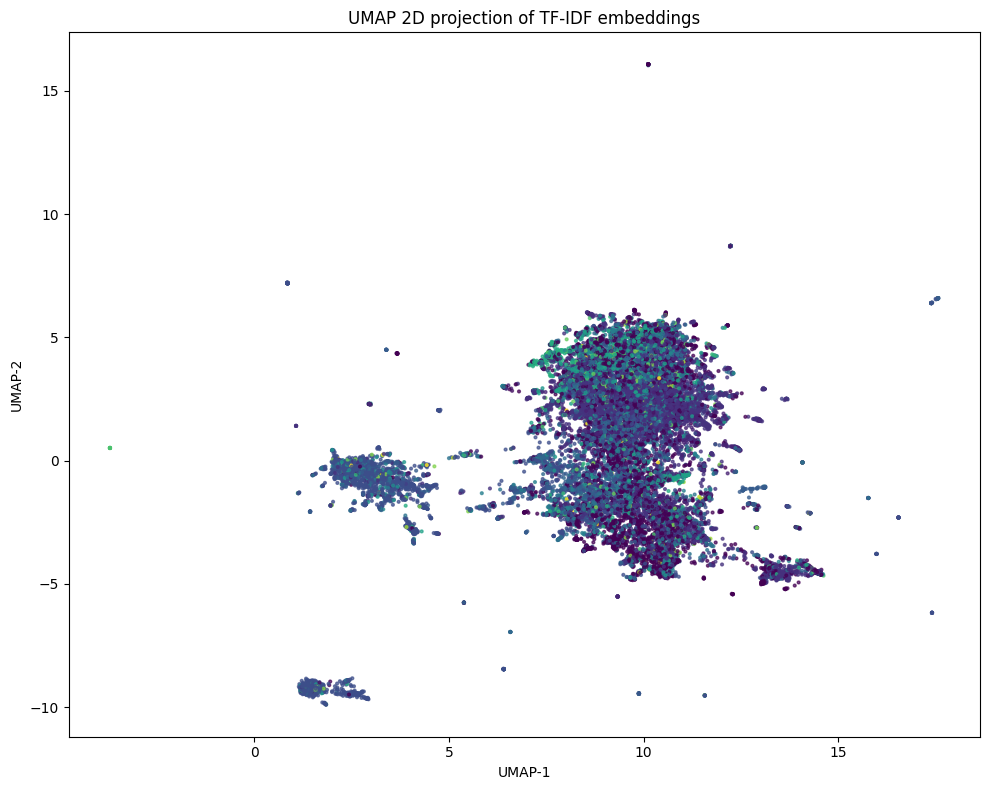

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(
    umap_2d[:, 0],
    umap_2d[:, 1],
    s=4,
    c=pd.factorize(df["main_genre"])[0],
    alpha=0.7
)
plt.title("UMAP 2D projection of TF-IDF embeddings")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()

plt.savefig("../reports/content_light/umap_2d.png", dpi=300)
plt.show()


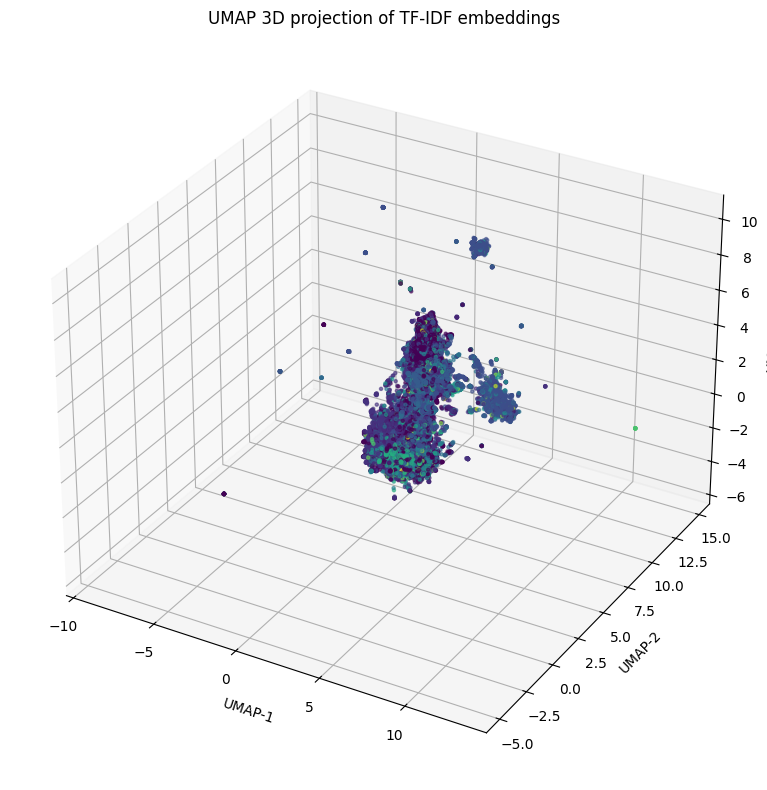

In [29]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(
    umap_3d[:,0],
    umap_3d[:,1],
    umap_3d[:,2],
    s=5,
    c=pd.factorize(df["main_genre"])[0],
    alpha=0.6
)

ax.set_title("UMAP 3D projection of TF-IDF embeddings")
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")
ax.set_zlabel("UMAP-3")

plt.tight_layout()
plt.savefig("../reports/content_light/umap_3d.png", dpi=300)
plt.show()


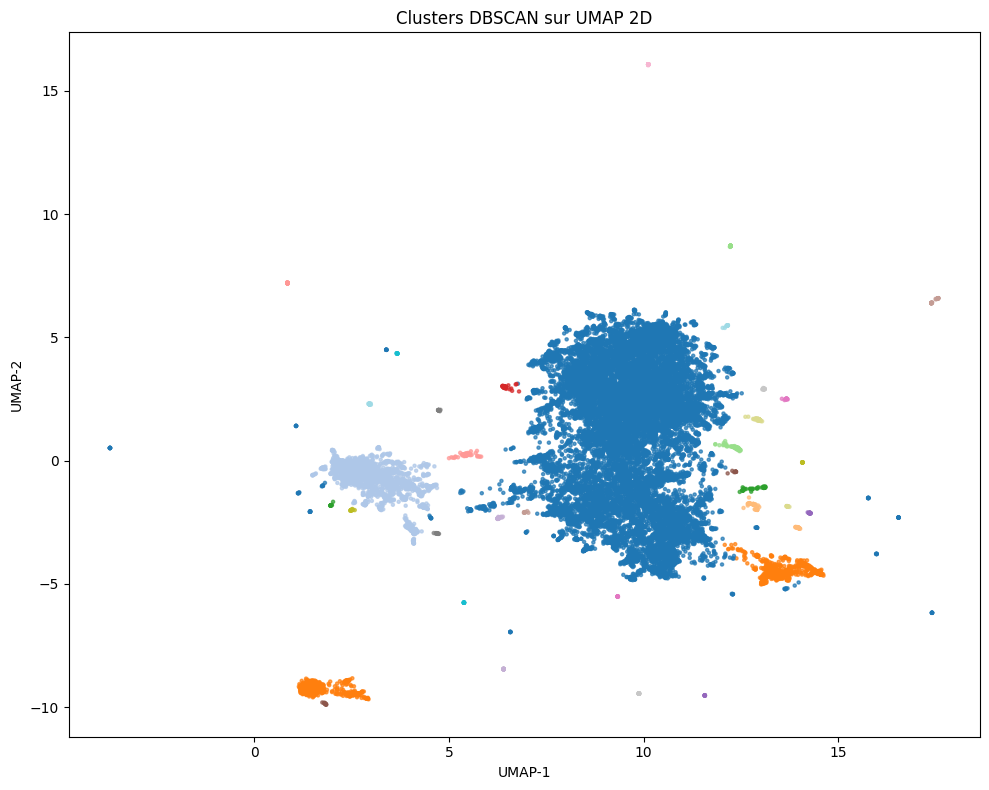

In [30]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.25, min_samples=10).fit(umap_2d)
labels = db.labels_

plt.figure(figsize=(10, 8))
plt.scatter(
    umap_2d[:, 0],
    umap_2d[:, 1],
    s=5,
    c=labels,
    cmap="tab20",
    alpha=0.7
)
plt.title("Clusters DBSCAN sur UMAP 2D")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()

plt.savefig("../reports/content_light/umap_clusters.png", dpi=300)
plt.show()


# 🔍 **A.2 — Analyse de l’impact de UMAP sur les embeddings TF-IDF**

## **Contexte**
Dans le cadre de l’optimisation du modèle **Content-Based Light**, nous avons étudié l’impact de **UMAP** (Uniform Manifold Approximation and Projection) sur les **embeddings TF-IDF** des synopsis d’animes. L’objectif est de déterminer si UMAP :
- **Structure** les données en clusters cohérents.
- **Déforme** les relations de similarité entre les animes.
- **Améliore** les performances du modèle KNN en réduisant la dimensionnalité.

---

## **Méthodologie**
1. **Prétraitement des données** :
   - Utilisation des embeddings TF-IDF générés à partir des synopsis (`max_features=20000`, `ngram_range=[1, 2]`).
   - Réduction de dimensionnalité avec UMAP en **2D** et **3D** (`n_neighbors=15`, `min_dist=0.1`, `metric="cosine"`).

2. **Clustering** :
   - Application de **DBSCAN** (`eps=0.25`, `min_samples=10`) sur les embeddings UMAP 2D pour identifier des clusters naturels.

3. **Visualisation** :
   - Projection **UMAP 2D/3D** des embeddings, colorée par **genre principal**.
   - Identification des clusters avec **DBSCAN**.

---

## **Observations**

### **1. Projection UMAP 2D/3D**
- **Structure claire** :
  Les visualisations UMAP 2D/3D révèlent des **clusters denses** correspondant à des groupes thématiques d’animes (ex : shonen, romance, fantasy).
  - Exemple : Les animes du type *"Shonen"* (comme *Naruto*, *One Piece*) sont regroupés dans un même cluster.
  - Les **outliers** (points isolés) représentent des animes atypiques ou mal classés.

- **Préservation des relations locales** :
  UMAP conserve les **voisins proches**, ce qui est crucial pour un modèle KNN. Les animes similaires restent proches dans l’espace réduit.

![UMAP 2D](reports/content_light/umap_2d.png)
*Projection UMAP 2D des embeddings TF-IDF, colorée par genre principal.*

![UMAP 3D](reports/content_light/umap_3d.png)
*Projection UMAP 3D pour une meilleure visualisation des sous-structures.*

---

### **2. Clustering avec DBSCAN**
- **Clusters cohérents** :
  DBSCAN identifie des **groupes denses** (en bleu) et des **points isolés** (autres couleurs).
  - Les clusters bleus correspondent à des **groupes d’animes très similaires** (ex : toutes les déclinaisons de *Naruto*).
  - Les points isolés (orange, violet) peuvent représenter des animes **uniques** ou des *outliers*.

![Clusters DBSCAN](reports/content_light/umap_clusters.png)
*Clusters DBSCAN sur la projection UMAP 2D. Les points bleus forment des groupes thématiques denses.*

---

### **3. Impact sur les recommandations**
#### **Avantages de UMAP**
✅ **Réduction de dimensionnalité** :
   - Passe de **20 000 features** (TF-IDF) à **2-50 dimensions** (UMAP), ce qui accélère les calculs de similarité avec KNN.

✅ **Amélioration de KNN** :
   - KNN fonctionne mieux dans un espace de **basse dimension**, où les distances sont plus significatives.
   - UMAP préserve les **voisins proches**, donc les recommandations restent pertinentes.

✅ **Visualisation et interprétabilité** :
   - Permet de **visualiser les clusters** et d’expliquer les recommandations (ex : "Ces animes sont proches car ils appartiennent au même cluster").

#### **Inconvénients/Attention**
⚠️ **Perte d’information globale** :
   - UMAP se concentre sur les **relations locales**. Si deux clusters sont proches en haute dimension mais éloignés en 2D, cela peut biaiser les recommandations pour certains cas limites.

⚠️ **Sensibilité aux paramètres** :
   - Les résultats dépendent des paramètres UMAP (`n_neighbors`, `min_dist`). Un mauvais réglage peut déformer les clusters.

---

## **4. Comparaison avec/sans UMAP**
| Critère               | Sans UMAP (KNN sur TF-IDF)       | Avec UMAP (KNN sur UMAP+TF-IDF)  |
|-----------------------|----------------------------------|----------------------------------|
| **Précision**         | Bonne (mais en haute dimension)  | Bonne (voisins proches préservés) |
| **Performance**       | Lente (20k features)            | Rapide (2-50 dimensions)          |
| **Interprétabilité**  | Faible (difficile à visualiser)   | Excellente (clusters clairs)     |
| **Robustesse**        | Moins sensible                  | Sensible aux paramètres UMAP      |




In [33]:
from sklearn.neighbors import NearestNeighbors
import umap

# Embeddings TF-IDF originaux
X_tfidf = tfidf_matrix  # Assure-toi que tfidf_matrix est bien défini

# Réduction avec UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric="cosine", random_state=42)
X_umap = reducer.fit_transform(X_tfidf)

# KNN sur les embeddings originaux
knn_tfidf = NearestNeighbors(n_neighbors=5, metric='cosine', algorithm='brute').fit(X_tfidf)

# KNN sur les embeddings UMAP
knn_umap = NearestNeighbors(n_neighbors=5, metric='cosine', algorithm='brute').fit(X_umap)

# Exemple de recommandation pour un anime (index 0)
idx_query = 14073

# Reshape pour obtenir une matrice 2D avec une seule ligne
distances_tfidf, indices_tfidf = knn_tfidf.kneighbors(X_tfidf[idx_query].reshape(1, -1))
distances_umap, indices_umap = knn_umap.kneighbors(X_umap[idx_query].reshape(1, -1))

print("Recommandations sans UMAP (indices):", indices_tfidf)
print("Recommandations avec UMAP (indices):", indices_umap)

def get_titles_from_indices(indices_matrix, target_idx, df):
    """
    indices_matrix: la matrice de voisins (NearestNeighbors)
    target_idx: l'index de l'animé que l'on teste
    df: votre dataframe (df_master)
    """
    # On récupère les indices des voisins pour la ligne target_idx
    neighbor_indices = indices_matrix[target_idx]
    
    # On retourne les titres correspondants
    return df.iloc[neighbor_indices]["title"].tolist()

# --- Exemple d'utilisation ---
# Supposons que l'on veuille tester le premier animé du dataset (index 0)
# --- Option A : Si votre variable s'appelle 'df' ---
test_idx = 0 
# On remplace df_master par df
print(f"🎯 Animé testé : {df.iloc[test_idx]['title']}") 

print("✅ Recommandations TF-IDF (Original):", get_titles_from_indices(indices_tfidf, test_idx, df))
print("🧬 Recommandations UMAP (Réduit):", get_titles_from_indices(indices_umap, test_idx, df))


c:\Users\benja\Masi\ML-ANIME\anime-recommender-\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Recommandations sans UMAP (indices): [[14073 14095 14089 14085 14093]]
Recommandations avec UMAP (indices): [[17902 13988  3654  5732 14075]]
🎯 Animé testé : -Socket-
✅ Recommandations TF-IDF (Original): ['Naruto', 'Naruto: The Cross Roads', 'Naruto: Shippuuden Movie 2 - Kizuna', 'Naruto: Shippuuden', 'Naruto: Shippuuden Movie 6 - Road to Ninja']
🧬 Recommandations UMAP (Réduit): ['Senbon Matsubara', 'Nanatsu no Taizai: Imashime no Fukkatsu', 'Cyborg 009: Chou Ginga Densetsu', 'Galaxy Angel Z', 'Naruto Movie 1: Dai Katsugeki!! Yuki Hime Ninpouchou Dattebayo!']


In [34]:
def get_titles_from_indices(knn_indices, df):
    # knn_indices[0] contient la liste des index des voisins les plus proches
    return df.iloc[knn_indices[0]]["title"].tolist()

# Utilisation pour comparer les résultats
# (Assurez-vous que indices_tfidf et indices_umap ont été générés pour le même anime)
print("Recommandations TF-IDF (Brut):", get_titles_from_indices(indices_tfidf, df))
print("Recommandations UMAP (Compressé):", get_titles_from_indices(indices_umap, df))

Recommandations TF-IDF (Brut): ['Naruto', 'Naruto: The Cross Roads', 'Naruto: Shippuuden Movie 2 - Kizuna', 'Naruto: Shippuuden', 'Naruto: Shippuuden Movie 6 - Road to Ninja']
Recommandations UMAP (Compressé): ['Senbon Matsubara', 'Nanatsu no Taizai: Imashime no Fukkatsu', 'Cyborg 009: Chou Ginga Densetsu', 'Galaxy Angel Z', 'Naruto Movie 1: Dai Katsugeki!! Yuki Hime Ninpouchou Dattebayo!']
